# Content personalization

## Without context

This example takes inspiration from Vowpal Wabbit's [excellent tutorial](https://vowpalwabbit.org/tutorials/cb_simulation.html).

Content personalization is about taking into account user preferences. It's a special case of recommender systems. Ideally, side-information should be taken into account in addition to the user. But we'll start with something simpler. We'll assume that each user has stable preferences that are independent of the context. We capture this by implementing a "reward" function.

In [1]:
def get_reward(user, item, context):

    time_of_day = context['time_of_day']

    USER_LIKED_ARTICLE = 1
    USER_DISLIKED_ARTICLE = 0

    if user == 'Tom':
        if time_of_day == 'morning' and item == 'politics':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif user == 'Anna':
        if time_of_day == 'morning' and item == 'sports':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

get_reward('Tom', 'politics', {'time_of_day': 'morning'})

1

Measuring the performance of a recommendation is not straightforward, mostly because of the interactive aspect of recommender systems. In a real situation, recommendations are presented to a user, and the user gives feedback indicating whether they like what they have been recommended or not. This feedback loop can't be captured entirely by a historical dataset. Some kind of simulator is required to generate recommendations and capture feedback. We already have a reward function. Now let's implement a simulation function.

In [2]:
import random
import matplotlib.pyplot as plt

def plot_ctr(ctr):
    plt.plot(range(1, len(ctr) + 1), ctr)
    plt.xlabel('n_iterations', fontsize=14)
    plt.ylabel('CTR', fontsize=14)
    plt.ylim([0, 1])
    plt.title(f'final CTR: {ctr[-1]:.2%}', fontsize=14)
    plt.grid()

users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
items = {'politics', 'sports', 'music', 'food', 'finance', 'health', 'camping'}

def simulate(n, reward_func, model, seed):
    
    rng = random.Random(seed)
    n_clicks = 0
    ctr = []  # click-through rate along time
    
    for i in range(n):
        
        # Generate a context at random
        user = rng.choice(users)
        context = {
            'time_of_day': rng.choice(times_of_day)
        }
    
        # Make a single recommendation
        item = model.rank(user, items=items, x=context)[0]
        
        # Measure the reward
        clicked = reward_func(user, item, context)
        n_clicks += clicked
        ctr.append(n_clicks / (i + 1))
        
        # Update the model
        model.learn_one(user, item, y=clicked, x=context)
        
    plot_ctr(ctr)

This simulation function does quite a few things. It can be seen as a simple reinforcement learning simulation. It samples a user, and then ask the model to provide a single recommendation. The user then gives as to whether they liked the recommendation or not. Crucially, the user doesn't tell us what item they would have liked. We could model this as a multi-class classification problem if that were the case.

The strategy parameter determines the mechanism used to generate the recommendations. The `'best'` strategy means that the items are each scored by the model, and are then ranked from the most preferred to the least preferred. Here the most preferred item is the one which gets recommended. But you could imagine all sorts of alternative ways to proceed.

We can first evaluate a recommended which acts completely at random. It assigns a random preference to each item, regardless of the user.

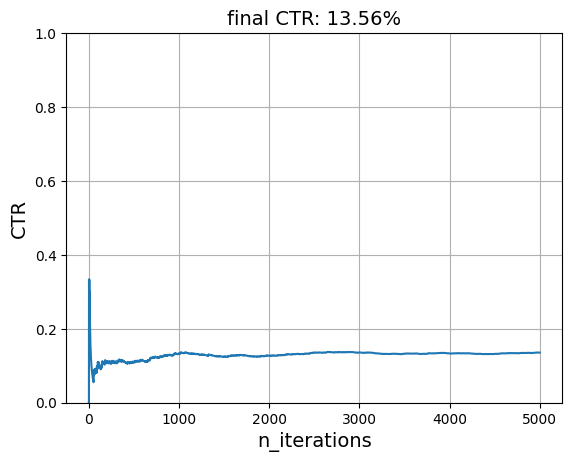

In [3]:
from river import reco

model = reco.RandomNormal(seed=10)
simulate(5_000, get_reward, model, seed=42)

We can see that the click-through rate (CTR) oscillates around 28.74%. In fact, this model is expected to be correct `100 * (2 / 7)% = 28.57%` of the time. Indeed, each user likes two items, and there are seven items in total.

Let's now use the `Baseline` recommended. This one models each preference as the following sum:

$$preference = \bar{y} + b_{u} + b_{i}$$

where

- $\bar{y}$ is the average CTR overall
- $b_{u}$ is the average CTR per user minus $\bar{y}$ -- it's therefore called a *bias*
- $b_{i}$ is the average CTR per item minus $\bar{y}$

This model is considered to be a baseline because it doesn't actually learn what items are preferred by each user. Instead it models each user and item separately. We shouldn't expect it to be a strong model. It should however do better than the random model used above.

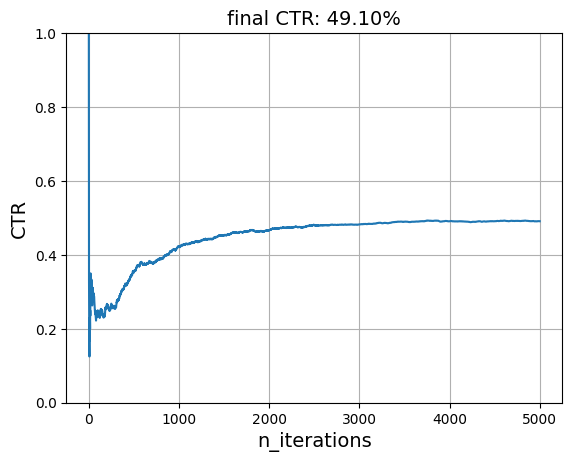

In [4]:
model = reco.Baseline(seed=10)
simulate(5_000, get_reward, model, seed=42)

This baseline model seems perfect, which is surprising. The reason why it works so well is because both users have in common that they both like politics. The model therefore learns that the `'politics'` is a good item to recommend.

In [5]:
model.i_biases

defaultdict(Zeros (),
            {'politics': 0.06389451550325113,
             'music': -0.04041254194187752,
             'finance': -0.040319730234734,
             'camping': -0.03581829597317823,
             'food': -0.037778771188204816,
             'health': -0.04029646665611086,
             'sports': -0.03661678982763635})

The model is not as performant if we use a reward function where both users have different preferences.

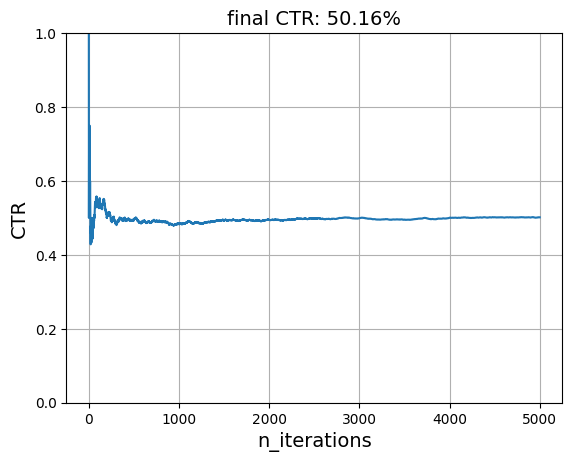

In [6]:
simulate(
    5_000,
    reward_func=lambda user, item, context: (
        item in {'music', 'politics'} if user == "Tom" else
        item in {'food', 'sports'}
    ),
    model=model,
    seed=42
)

A good recommender model should at the very least understand what kind of items each user prefers. One of the simplest and yet performant way to do this is Simon Funk's SGD method he developped for the Netflix challenge and wrote about [here](https://sifter.org/simon/journal/20061211.html). It models each user and each item as latent vectors. The dot product of these two vectors is the expected preference of the user for the item.

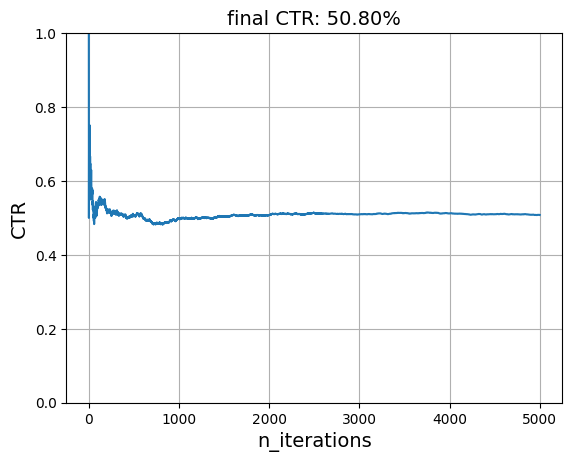

In [7]:
model = reco.FunkMF(seed=10)
simulate(5_000, get_reward, model, seed=42)

We can see that this model learns what items each user enjoys very well. Of course, there are some caveats. In our simulation, we ask the model to recommend the item most likely to be preferred for each user. Indeed, we rank all the items and pick the item at the top of the list. We do this many times for only two users.

This is of course not realistic. Users will get fed up with recommendations if they're always shown the same item. It's important to include diversity into recommendations, and to let the model explore other options instead of always focusing on the item with the highest score. This is where evaluating recommender systems gets tricky: the reward function itself is difficult to model.

We will keep ignoring these caveats in this notebook. Instead we will focus on a different concern: making recommendations when context is involved.

## With context

We'll add some context by making it so that user preferences change depending on the time the day. Very simply, preferences might change from morning to afternoon. This is captured by the following reward function.

In [8]:
times_of_day = ['morning', 'afternoon']

def get_reward(user, item, context):
    if user == 'Tom':
        if context['time_of_day'] == 'morning':
            return item == 'politics'
        if context['time_of_day'] == 'afternoon':
            return item == 'music'
    if user == 'Anna':
        if context['time_of_day'] == 'morning':
            return item == 'sports'
        if context['time_of_day'] == 'afternoon':
            return item == 'politics'

We have to update our simulation function to generate a random context at each step. We also want our model to use it for recommending items as well as learning.

In [9]:
def simulate(n, reward_func, model, seed):
    
    rng = random.Random(seed)
    n_clicks = 0
    ctr = []
    
    for i in range(n):
        
        user = rng.choice(users)
        
        # New: pass a context
        context = {'time_of_day': rng.choice(times_of_day)}
        item = model.rank(user, items, context)[0]
        
        clicked = reward_func(user, item, context)
        n_clicks += clicked
        ctr.append(n_clicks / (i + 1))
        
        # New: pass a context
        model.learn_one(user, item, clicked, context)
        
    plot_ctr(ctr)

Not all models are capable of taking into account context. For instance, the `FunkMF` model only models users and items. It completely ignores the context, even when we provide one. All recommender models inherit from the base `Recommender` class. They also have a property which indicates whether or not they are able to handle context:

In [10]:
model = reco.FunkMF(seed=10)
model.is_contextual

False

Let's see well it performs.

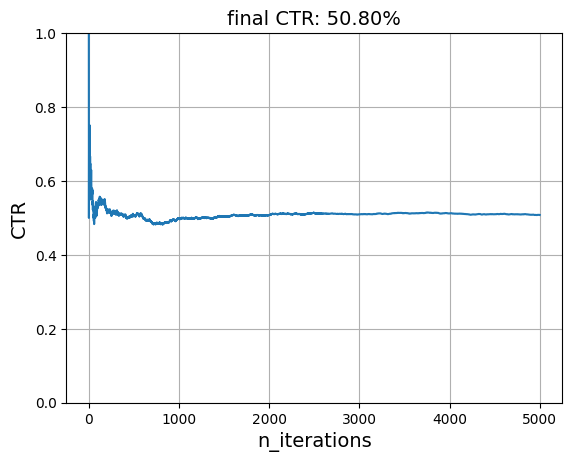

In [11]:
simulate(5_000, get_reward, model, seed=42)

The performance has roughly been divided by half. This is most likely because there are now two times of day, and if the model has learnt preferences for one time of the day, then it's expected to be wrong half of the time.

Before delving into recsys models that can handle context, a simple hack is to notice that we can append the time of day to the user. This effectively results in new users which our model can distinguish between. We could apply this trick during the simulation, but we can also override the behavior of the `learn_one` and `rank` methods of our model.

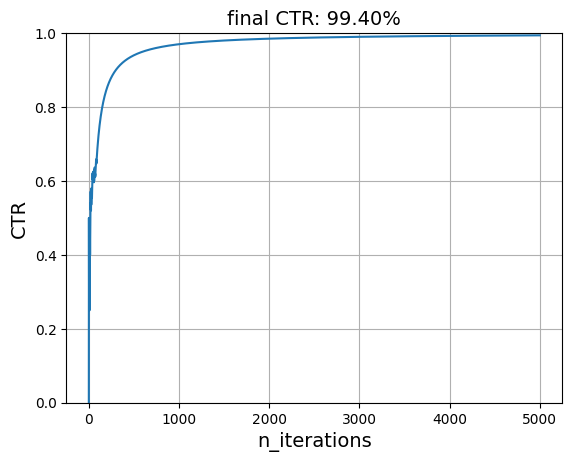

In [12]:
class FunkMFWithHack(reco.FunkMF):

    def learn_one(self, user, item, reward, context):
        user = f"{user}@{context['time_of_day']}"
        return super().learn_one(user, item, reward, context)

    def rank(self, user, items, context):
        user = f"{user}@{context['time_of_day']}"
        return super().rank(user, items, context)

model = FunkMFWithHack(seed=29)
simulate(5_000, get_reward, model, seed=42)

We can verify that the model has learnt the correct preferences by looking at the expected preference for each `(user, item)` pair.

In [13]:
import pandas as pd

(
    pd.DataFrame(
        {
            'user': user,
            'item': item,
            'preference': model.predict_one(user, item)
        }
        for user in model.u_latents
        for item in model.i_latents
    )
    .pivot(index='user', columns='item')
    .style.highlight_max(color='lightgreen', axis='columns')
)